In [ ]:
import json
import torch
import transformers
import matplotlib.pyplot as plt
import pandas as pd
from openai import OpenAI
from tqdm import tqdm
import os

In [4]:
# load environment vars
from dotenv import load_dotenv

load_dotenv()
OPENAI_API_KEY = os.getenv("API_KEY")

## 1. Read and format dataset

In [7]:
cloze_dir = "data/cloze"
cloze_files = os.listdir(cloze_dir)
cloze_files

['cloze_test_test__winter2018-cloze_test_ALL_test - 1.csv',
 'cloze_test_val__winter2018-cloze_test_ALL_val - 1 - 1.csv',
 'val_set.json',
 'val_set_knowledge.json']

In [8]:
test_set = pd.read_csv(f"{cloze_dir}/{cloze_files[0]}")
val_set = pd.read_csv(f"{cloze_dir}/{cloze_files[1]}")

In [9]:
print("Validation size : ", val_set.shape[0])
print("Test size : ", test_set.shape[0])

Validation size :  1571
Test size :  1571


In [10]:
def printSample(df, idx):
    for col in df.columns[1:]:
        print(col, df.loc[idx, col])

In [11]:
printSample(val_set, 1)

InputSentence1 Laverne needs to prepare something for her friend's party.
InputSentence2 She decides to bake a batch of brownies.
InputSentence3 She chooses a recipe and follows it closely.
InputSentence4 Laverne tests one of the brownies to make sure it is delicious.
RandomFifthSentenceQuiz1 The brownies are so delicious Laverne eats two of them.
RandomFifthSentenceQuiz2 Laverne doesn't go to her friend's party.
AnswerRightEnding 1


### 1.1 Format samples

In [8]:
def formatSet(dataset, save_path):
    '''
    Format ROC cloze dataset to json and save.
    '''
    # convert dataframe to list of dictionaries
    val_dicts = dataset.T.to_dict()
    val_list = [val_dicts[x] for x in val_dicts.keys()]

    # process each sample to put in correct format
    for idx in range(len(val_list)):
        dict_at_idx = val_list[idx]

        # add each plausible candidate to list
        dict_at_idx["cands"] = [dict_at_idx["RandomFifthSentenceQuiz1"], dict_at_idx["RandomFifthSentenceQuiz2"]]

        # store the correct ending to answer variable
        dict_at_idx["answer"] = dict_at_idx["cands"][dict_at_idx["AnswerRightEnding"] - 1]

        # concatenate all input sentences into a single string
        dict_at_idx["query"] = " ".join([dict_at_idx[f"InputSentence{x}"] for x in range(1, 5)])

        # remove redundant variables
        for x in range(1,5):
            del dict_at_idx[f"InputSentence{x}"]

        del dict_at_idx["AnswerRightEnding"]
        del dict_at_idx["RandomFifthSentenceQuiz1"]
        del dict_at_idx["RandomFifthSentenceQuiz2"]

    
    # save
    with open(save_path,  "w") as output:
        json.dump(val_list, output, indent=2)


    return val_list



In [10]:
_ = formatSet(val_set, f"{cloze_dir}/val_set.json")
#_ = formatSet(test_set, f"{cloze_dir}/test_set.json") # test set missing a tag

## 2. Knowledge Generation
### 2.1 Prepare prompts

In [ ]:
prompt_path = "knowledge/prompts/cloze_prompt.txt"
input_path = f"{cloze_dir}/val_set.json"

In [41]:
'''
# engine = "davinci" OBSOLETE
engine = "davinci-002"
max_tokens = 60
temperature = 1.0
top_p = 1.0
n = 1
stop='\n'
presence_penalty=frequency_penalty=0.0
'''

In [13]:
data_df = pd.read_json(input_path)
data_df.head()

,InputStoryid,cands,answer,query
0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,"[He is happy now., He joined a gang.]",He is happy now.,Rick grew up in a troubled household. He never...
1,bff9f820-9605-4875-b9af-fe6f14d04256,[The brownies are so delicious Laverne eats tw...,The brownies are so delicious Laverne eats two...,Laverne needs to prepare something for her fri...
2,e8f628d5-9f97-40ed-8611-fc0e774673c4,"[Sarah then decided to move to Europe., Sarah ...",Sarah decided that she preferred her home over...,Sarah had been dreaming of visiting Europe for...
3,f5226bfe-9f26-4377-b05f-3d9568dbdec1,[Gina liked the cookies so much she ate them a...,Gina liked the cookies so much she ate them al...,Gina was worried the cookie dough in the tube ...
4,69ac9b05-b956-402f-9fff-1f926ef9176b,"[I was very proud of my performance., I was ve...",I was very proud of my performance.,It was my final performance in marching band....


In [70]:
with open(prompt_path) as f:
    context_prompt = f.read().strip('\n')   

print("This is the example prompt to generate the contextual knowledge:")
print(context_prompt)

This is the example prompt to generate the contextual knowledge:
Generate some knowledge about the concepts in the input. Examples:

Input: Sophie discovers a box of old photographs in her grandmother's basement. Fascinated, she spends the afternoon looking through them. Among the photos, she finds several of a young woman she doesn't recognize. Sophie decides to ask her grandmother about the woman.
Knowledge: Basements are often used as storage spaces in houses, providing a cool and dry place for items not frequently used.

Input: Evan plants a small vegetable garden in his backyard. He carefully selects a variety of seeds: tomatoes, carrots, and lettuce. Every day, he waters them and checks for any signs of growth. After a few weeks, sprouts begin to appear.
Knowledge: Tomatoes are botanically classified as fruits because they contain seeds and develop from the flowering part of plants.

Input: Liam finds a stray kitten hiding under his car one evening. He gently coaxes it out with s

In [84]:
def prompt_format(query: str, context_prompt: str):
    '''
    Append queries to a predefined prompt. 
    Return a list of modified prompts.
    '''
    new_prompt = context_prompt.replace('{question}', query)
    return {'role':'user', 'content': new_prompt}

### 2.2 Query GPT model 

In [ ]:
# instantiate openAI client 
client = OpenAI(api_key=OPENAI_API_KEY)

# gpt query params
num_knowledge=20
top_p=0.5
temperature=1.0
max_tokens=60
model="gpt-3.5-turbo-instruct"
n = 1
stop='\n'
presence_penalty=frequency_penalty=0.0

In [68]:
def request(
    prompt: str,
    model="gpt-3.5-turbo",
    max_tokens=60,
    temperature=1.0,
    top_p=1.0,
    n=1,
    stop='\n',
    presence_penalty=0.0,
    frequency_penalty=0.0,
    ):
    '''
    Queries the gpt model to create relevant, contextual and factual information given the input. 
    '''
    # retry request (handles connection errors, timeouts, and overloaded API)
    
    while True:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[prompt],
                max_tokens=max_tokens,
                temperature=temperature,
                top_p=top_p,
                n=n,
                stop=stop,
                presence_penalty=presence_penalty,
                frequency_penalty=frequency_penalty,
            )
            break
        except Exception as e:
            tqdm.write(str(e))
            tqdm.write("Retrying...")
            import time
            time.sleep(60)
    
    return response.choices[0].message.content

In [88]:
output_path = f"{cloze_dir}/val_set_knowledge.json"

In [90]:
generated_examples = []

# traverse the dataset, creating for each sample a context 
for _, row in tqdm(data_df.iterrows()):
    context_string = prompt_format(query=row['query'], context_prompt=context_prompt)
    knowledge = request(context_string)

    row['knowledge'] = knowledge
    generated_examples.append(row.to_dict())

# save to json
with open(output_path, 'w') as fo:
    json.dump(generated_examples, fo, indent=4)

1571it [22:54,  1.14it/s]


## 3. Inference Example

### 3.1 Inference - Single Sample

In [12]:
# read in dataset 
input_path = f"{cloze_dir}/val_set.json"

with open(input_path) as f:
    ds = json.load(f)

ds[0]

{'InputStoryid': '138d5bfb-05cc-41e3-bf2c-fa85ebad14e2',
 'cands': ['He is happy now.', 'He joined a gang.'],
 'answer': 'He is happy now.',
 'query': "Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf."}

In [18]:
# dummy object to simulate inputs
class dummyArgs:

    def __init__(self, task, model_type, model_ckpt, input_path, avg_loss, interactive, h=1, v=1, n=None, aggfunc="best_prob"):
        self.task = task
        self.model_type = model_type
        self.model_ckpt = model_ckpt
        self.input_path = input_path
        self.avg_loss = avg_loss
        self.h = h
        self.v = v
        self.aggfunc = aggfunc
        self.interactive = interactive
        self.n = n

In [19]:
# instantiate tokenizer and model
args = dummyArgs("cloze", "t5-base", None, f"{cloze_dir}/val_set.json", None, None)
tokenizer = transformers.T5Tokenizer.from_pretrained(args.model_type)
model = transformers.T5ForConditionalGeneration.from_pretrained(args.model_ckpt if args.model_ckpt is not None else args.model_type)
model.cuda()
model.eval()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [117]:
# get single item from dataset
item = ds[0]
query = item['query'] if 'query' in item else item['question']
cands = item['cands']
knowledges = None
if "knowledges" in item:
    knowledges = item["knowledges"]
print("Query", query)
print("Cands", cands)
print("Knowledges", knowledges)

Query Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf.
Cands ['He is happy now.', 'He joined a gang.']
Knowledges None


#### Pass Without knowledge

In [118]:
# initiate array to store loss scores and candidate probabilities
n = len(knowledges) if knowledges is not None else 0
h, v = args.h, args.v
scores_, probs_ = [], []

In [119]:
# concatenate query and candiadates 
source = query

targets = [f'<extra_id_0> {cand} <extra_id_1>' for cand in cands]
#targets = cands
print(source)

Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf.


In [120]:
# tokenize the query
scores = []
input_ids = tokenizer(source, return_tensors='pt').input_ids.cuda()
input_ids

tensor([[11066,     3,  4774,    95,    16,     3,     9,  3169,    26,  5699,
             5,   216,   470,   435,   207,   380,    16,   384,     6,    11,
          2120,    12,     3,  3810,     7,     5,    94,  2088,    31,    17,
           307,   274, 11066,   530,  2538,    16,     3,     9,     3,  5840,
          1152,    63,     5,    37,  5415,  2953,   376,    12,   919,     3,
             9,   126,  8384,     5,     1]], device='cuda:0')

In [ ]:
# run to see all how all tokens were tokenized and identified
#tokens = tokenizer.convert_ids_to_tokens(input_ids.cpu().data.numpy()[0])
#for t in tokens:
    #print(t)

#print(f"Number of tokens: {len(tokens)}")

In [122]:
# calculate loss and softmax probabilities for each possible answer
for i, _ in enumerate(cands):

    # get the token for the ith possible output
    labels = tokenizer(targets[i], return_tensors='pt').input_ids.cuda()

    # calculate loss for the ith candidate
    with torch.no_grad():
        loss = model(input_ids=input_ids, labels=labels).loss.item() # mean reduction

    if not args.avg_loss:
        loss *= labels.size(1)

    # add loss to the scores array
    score = -loss
    scores.append(score)

scores = torch.tensor(scores)
probs = torch.softmax(scores, dim=0)
print(scores)
print([(cand, prob) for cand, prob in zip(cands,probs)])

scores_.append(scores)
probs_.append(probs)

placeholder_scores_ = scores_
placeholder_probs_ = probs_

tensor([-29.7580, -21.2826])
[('He is happy now.', tensor(0.0002)), ('He joined a gang.', tensor(0.9998))]


#### Predict without knowledge

In [123]:
scores_ = torch.stack(scores_, dim=0)
probs_ = torch.stack(probs_, dim=0)

print(scores_)
print(probs_)

tensor([[-29.7580, -21.2826]])
tensor([[2.0849e-04, 9.9979e-01]])


In [124]:
query

"Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf."

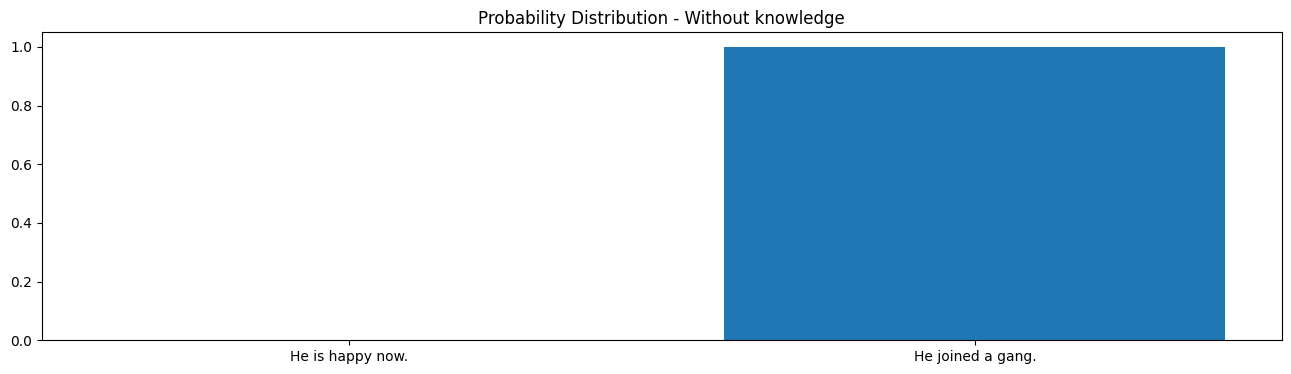

In [126]:
fig, ax = plt.subplots(figsize=(16,4))
ax.bar(cands, probs_.tolist()[0])
ax.set_title("Probability Distribution - Without knowledge")
plt.show()

In [127]:
# retrieve prediction (highest probability)
p = probs.argmax().item()
pred = cands[p]
pred

'He joined a gang.'

### 3.2 Inference - Without Knowledge - Process all samples.

In [26]:
def score_for_input(args, tokenizer, model, query, cands, knowledge=None):
    source, targets = None, None
    # process inputs and candidates for model
    source = query
    if knowledge is not None:
        source = f'{knowledge} {source}'
    targets = [f'<extra_id_0> {cand} <extra_id_1>' for cand in cands]

    # tokenize query text
    input_ids = tokenizer(source, return_tensors='pt').input_ids.cuda()

    # calculate loss and probability distribution across candidates
    scores = []
    for i, _ in enumerate(cands):
        labels = tokenizer(targets[i], return_tensors='pt').input_ids.cuda()
        with torch.no_grad():
            loss = model(input_ids=input_ids, labels=labels).loss.item() # mean reduction
        if not args.avg_loss:
            loss *= labels.size(1)
        score = -loss
        scores.append(score)
        
    scores = torch.tensor(scores)
    probs = torch.softmax(scores, dim=0)
    return scores, probs


def score_for_query(args, tokenizer, model, query, knowledges, cands):
    n = len(knowledges)
    h, v = args.h, args.v
    if len(knowledges)!=0:
        print("Knowledges detected!")
        print(f"Knowledge detected: {knowledges[0]}")
        if h == -1 and v == -1:
            raise Exception('h and v cannot be both -1!')
        if h * v > n:
            raise Exception('h*v must be no larger than the number of knowledges!')
        if h == -1:
            h = n // v
        if v == -1:
            v = n // h

    scores_, probs_ = [], []

    # a pass w/o knowledge
    scores, probs = score_for_input(args, tokenizer, model, query, cands)
    scores_.append(scores)
    probs_.append(probs)

    # with knowledge
    if len(knowledges) > 0:
        for i in range(0, v * h, h):
            knowledge = ' '.join(knowledges[i:i+h])
            print("Incoming knowledge", knowledge)
            scores, probs = score_for_input(args, tokenizer, model, query, cands, knowledge)
            scores_.append(scores)
            probs_.append(probs)

    return torch.stack(scores_), torch.stack(probs_)

In [27]:
def checker(answer, pred):
    return 1 if answer == pred else 0

def process_item(args, tokenizer, model, item):

    # retrieve the query
    query = item['query'] if 'query' in item else item['question']

    # retrieve the possible options
    if 'cands' in item:
        cands = item['cands']
    else:
        raise Exception('Candidates not in sample.')

    # retrieve knowledge if available
    knowledges = [item['knowledge']] if 'knowledge' in item else []

    # calculate loss and probabilities for all candidates
    scores_, probs_ = score_for_query(args, tokenizer, model, query, knowledges, cands)
    scores, _ = torch.max(scores_, dim=0)
    probs, _ = torch.max(probs_, dim=0)

    # calculate prediction according to selected criterion
    if args.aggfunc == 'best_score':
        p = scores.argmax().item()
    elif args.aggfunc == 'best_prob':
        p = probs.argmax().item()
    elif args.aggfunc == 'poe':
        probs = torch.prod(probs_, dim=0)
        p = probs.argmax().item()
    elif args.aggfunc == 'moe':
        probs = torch.sum(probs_, dim=0)
        p = probs.argmax().item()
    pred = cands[p]

    # add results to item
    item['scores_'] = scores_.tolist()
    item['probs_'] = probs_.tolist()
    item['scores'] = scores.tolist()
    item['probs'] = probs.tolist()
    item['pred'] = pred

    if 'answer' in item:
        answer = item['answer']
        ok = checker(answer, pred)
        item['ok'] = ok

In [143]:
pbar = tqdm(ds)
num, den = 0, 0
for item in pbar:
    process_item(args, tokenizer, model, item)
    if 'ok' in item:
        num += item['ok']
        den += 1
        pbar.set_postfix({'acc': num / den})

100%|██████████████████████████████████████████████████████████████████████████████████████| 1571/1571 [07:28<00:00,  3.50it/s, acc=0.545]


### 3.3 Inference - With Knowledge - Process all samples.

In [29]:
# read in dataset 
input_path = f"{cloze_dir}/val_set_knowledge.json"

with open(input_path) as f:
    ds = json.load(f)

ds[0]

{'InputStoryid': '138d5bfb-05cc-41e3-bf2c-fa85ebad14e2',
 'cands': ['He is happy now.', 'He joined a gang.'],
 'answer': 'He is happy now.',
 'query': "Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf.",
 'knowledge': "Growing up in a challenging environment can impact a person's choices and lead them down negative paths such as joining gangs. Traumatic experiences like getting shot can sometimes serve as a turning point for individuals, motivating them to make positive changes in their lives."}

In [25]:
pbar = tqdm(ds)
num, den = 0, 0
for item in pbar:
    process_item(args, tokenizer, model, item)
    if 'ok' in item:
        num += item['ok']
        den += 1
        pbar.set_postfix({'acc': num / den})

100%|██████████████████████████████████████████████████████████████████████████████████████| 1571/1571 [14:47<00:00,  1.77it/s, acc=0.562]
